In [1]:
import numpy as np
from importlib.resources import files
import math
import dill
from matplotlib import pyplot as plt
from pyomo import environ as pyo

In [16]:
from interarray.interarraylib import L_from_site, as_normalized, G_from_S, NodeTagger, S_from_G
from interarray.svg import svgplot
from interarray.plotting import gplot, pplot
from interarray.mesh import make_planar_embedding
from interarray.baselines.hgs import iterative_hgs_cvrp, hgs_multiroot
from interarray.importer import load_repository, L_from_yaml
from interarray.pathfinding import PathFinder
import interarray.MILP.pyomo as omo
from interarray.EW_presolver import EW_presolver

In [3]:
%config InlineBackend.figure_formats = ['svg']
plt.rcParams['svg.fonttype'] = 'none'

In [4]:
solver = pyo.SolverFactory('gurobi', solver_io='python')

## Reference solution (do not run cell)

Taylor, P., Yue, H., Campos-Gaona, D., Anaya-Lara, O., & Jia, C. (2023). Wind farm array cable layout optimisation for complex offshore sites—A decomposition based heuristic approach. IET Renewable Power Generation, 17(2), 243–259. https://doi.org/10.1049/rpg2.12593

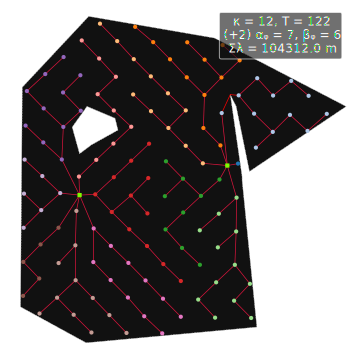

In [51]:
ax = gplot(G, landscape=False)

## Start here

In [9]:
L = L_from_yaml(files('interarray.data') / 'Taylor-2023.yaml')

In [ ]:
for n, nodeD in L.nodes(data=True):
    nodeD['label'] = n

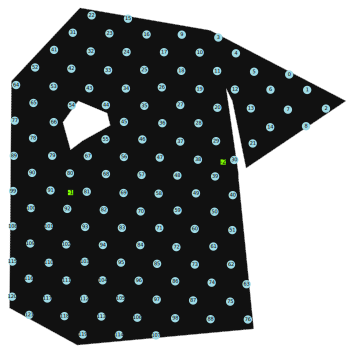

In [40]:
gplot(L, landscape=False, node_tag='label');

In [10]:
P, A = make_planar_embedding(L)

In [11]:
Sʹ = EW_presolver(A, 12)

In [12]:
Gʹ = G_from_S(Sʹ, A)

In [13]:
Hʹ = PathFinder(Gʹ, planar=P, A=A).create_detours()

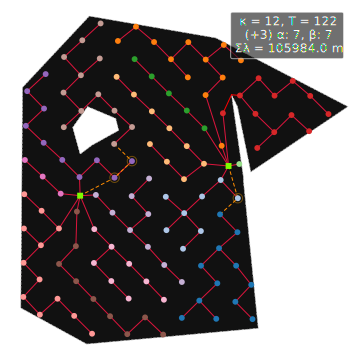

In [15]:
gplot(Hʹ, landscape=False);

In [21]:
Sʹ = hgs_multiroot(A, capacity=12, time_limit=0.5)

In [22]:
Sʹ.graph['solution_time']

(0.2, 0.23)

In [23]:
Gʹ = G_from_S(Sʹ, A)

In [24]:
Hʹ = PathFinder(Gʹ, planar=P, A=A).create_detours()

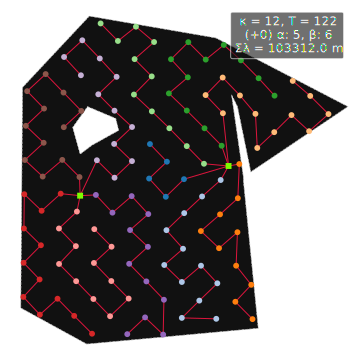

In [25]:
gplot(Hʹ, landscape=False);

In [1]:
1 - 103312/104312

0.00958662474116112

In [32]:
# build model and pre-load solution from Sʹ
model = omo.make_min_length_model(
    A, Sʹ.graph['capacity'],
    gateXings_constraint=False,
    gates_limit=False,
    branching=True
)
omo.warmup_model(model, Sʹ)

In [33]:
solver.options.mipgap = 0.001  # 0.5 %
solver.options.timelimit = 5  # [s]
# solver.options.mipfocus = 1  # focus on producing solutions
print(f'Solving "{model.handle}": {{R={len(model.R)}, T={len(model.T)}, k={model.k.value}}}\n')
status = solver.solve(model, warmstart=model.warmed_by, tee=True)

Solving "None": {R=2, T=122, k=12}

Set parameter OutputFlag to value 1
Set parameter MIPGap to value 0.001
Set parameter TimeLimit to value 10
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
TimeLimit  10
MIPGap  0.001

Academic license 937681 - for non-commercial use only - registered to ma___@dtu.dk
Optimize a model with 4444 rows, 2896 columns and 16572 nonzeros
Model fingerprint: 0xffbdaa38
Variable types: 0 continuous, 2896 integer (1448 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [4e+02, 1e+04]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 1e+02]

Loaded user MIP start with objective 103312

Presolve removed 653 rows and 0 columns
Presolve time: 0.02s
Presolved: 3791 rows, 2896 columns, 13820

In [34]:
H = omo.gurobi_investigate_pool(P, A, model, solver, status)

Solution pool has 10 solutions.
Incumbent has (detoured) length: 100794.971
Pool investigation over - next best undetoured length: 100823.278


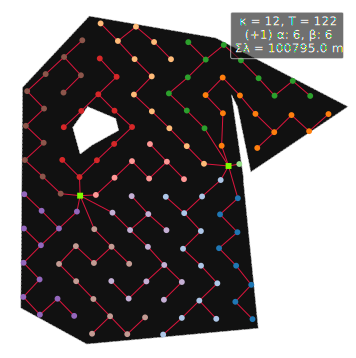

In [35]:
ax = gplot(H, landscape=False)

In [36]:
1 - 100795/104312

0.033716159214663755

In [35]:
ax.figure.savefig('Taylor_comparison_κ_12_branched_ours.svg')

In [30]:
with open('Taylor_comparison_κ_12_branched_ours.dill', 'wb') as outfile:
    dill.dump(G, outfile)